In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
import cartopy.crs as ccrs
import os
#from pyproj import CRS
import geopandas as gpd
#from pykrige.ok import OrdinaryKriging
from osgeo import osr
from osgeo import gdal
from scipy.spatial import distance_matrix
#from scipy.interpolate import Rbf
import rasterio as rio
import itertools as it
from pyproj import Transformer, CRS


path_data = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data')
path_out = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results')

In [ ]:
# Read and intersect the valid data

lab_chemical_properties = pd.read_csv(
    os.path.join(path_data, 'NCSSLabDataMart_MSAccess', 'lab_chemical_properties_vw.csv')
).set_index('layer_key')[['ca_nh4_ph_7', 'ca_nh4_ph_7_method', 
                          'mg_nh4_ph_7', 'mg_nh4_ph_7_method', 
                          'na_nh4_ph_7', 'na_nh4_ph_7_method', 
                          'k_nh4_ph_7', 'k_nh4_ph_7_method',
                          'acidity_bacl2_tea_ph_8_2', 'acidity_bacl2_tea_ph_82_method',
                          'aluminum_kcl_extractable', 'aluminum_kcl_extract_method', 
                          'cec_nh4_ph_7', 'cec_nh4_ph_7_method']]

layer_properties = pd.read_csv(
    os.path.join(path_data, 'NCSSLabDataMart_MSAccess', 'ncss_labdata_lab_layer.csv')
)[['layer_key', 'site_key', 'hzn_top', 'hzn_bot']].set_index('layer_key')
layer_properties['hzn_node'] = layer_properties[['hzn_top', 'hzn_bot']].mean(axis = 1)
layer_properties['hzn_thickness'] = layer_properties['hzn_bot'] - layer_properties['hzn_top']
# remove invalid and negative layers
layer_properties = layer_properties.dropna(axis = 0, how = 'any')
layer_properties = layer_properties.query('hzn_top >= 0. and hzn_thickness >= 0.')
layer_properties['site_key'] = layer_properties['site_key'].astype(np.int64)

# layer that has a site key
common_layers = lab_chemical_properties.index.intersection(layer_properties.index)
lab_chemical_properties = lab_chemical_properties.loc[common_layers, :]
layer_properties = layer_properties.loc[common_layers, :]

site_coords = pd.read_csv(
    os.path.join(path_data, 'NCSSLabDataMart_MSAccess', 'lab_site.csv')
)[['site_key', 'latitude_std_decimal_degrees', 
   'longitude_std_decimal_degrees']].set_index('site_key')

# remove sites without coordinates / outside the US
site_coords = site_coords.dropna(axis = 0, how = 'any')
site_coords = site_coords.query(
    'latitude_std_decimal_degrees >= 25 and latitude_std_decimal_degrees <= 50 and longitude_std_decimal_degrees >= -130 and longitude_std_decimal_degrees <= -65'
)

# site that has a lat lon
valid_layers = layer_properties['site_key'].isin(site_coords.index)
lab_chemical_properties = lab_chemical_properties.loc[valid_layers, :]
layer_properties = layer_properties.loc[valid_layers, :]

# add site info to the lab chemical properties
layer_to_site = layer_properties['site_key'].to_dict()
lab_chemical_properties['site_key'] = [layer_to_site[i] for i in lab_chemical_properties.index]
lab_chemical_properties['lat'] = [site_coords.loc[layer_to_site[i], 'latitude_std_decimal_degrees'] for i in lab_chemical_properties.index]
lab_chemical_properties['lon'] = [site_coords.loc[layer_to_site[i], 'longitude_std_decimal_degrees'] for i in lab_chemical_properties.index]
lab_chemical_properties['hzn_top'] = [layer_properties.loc[i, 'hzn_top'] for i in lab_chemical_properties.index]
lab_chemical_properties['hzn_bot'] = [layer_properties.loc[i, 'hzn_bot'] for i in lab_chemical_properties.index]

<ipython-input-2-0d025f747561>:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  lab_chemical_properties = pd.read_csv(
<ipython-input-2-0d025f747561>:13: DtypeWarning: Columns (9,10,11,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  layer_properties = pd.read_csv(
<ipython-input-2-0d025f747561>:28: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  site_coords = pd.read_csv(


In [ ]:
print(lab_chemical_properties['ca_nh4_ph_7_method'].drop_duplicates().sort_values())
print(lab_chemical_properties['mg_nh4_ph_7_method'].drop_duplicates().sort_values())
print(lab_chemical_properties['na_nh4_ph_7_method'].drop_duplicates().sort_values())
print(lab_chemical_properties['k_nh4_ph_7_method'].drop_duplicates().sort_values())
print(lab_chemical_properties['aluminum_kcl_extract_method'].drop_duplicates().sort_values())
print(lab_chemical_properties['acidity_bacl2_tea_ph_82_method'].drop_duplicates().sort_values())
print(lab_chemical_properties['cec_nh4_ph_7_method'].drop_duplicates().sort_values())

layer_key
15790365     4B1a1
15873496    4B1a1a
15818068       6N2
15927644      6N2a
10223         6N2b
6998          6N2c
32043         6N2d
15733477      6N2e
153526        6N2f
153840        6N2i
162514        6N2j
38121         6N3a
24372           NK
27065          NaN
Name: ca_nh4_ph_7_method, dtype: object
layer_key
15790365     4B1a1
15873496    4B1a1a
15818068       6O2
15927644      6O2a
10223         6O2b
8008          6O2c
15733477      6O2d
153526        6O2e
153840        6O2h
162514        6O2i
38121         6O3a
24372           NK
18923          NaN
Name: mg_nh4_ph_7_method, dtype: object
layer_key
15790365     4B1a1
15873496    4B1a1a
15818068       6P2
15733477      6P2a
59071         6P2b
153526        6P2c
153840        6P2f
162514        6P2g
24372           NK
15745175       NaN
Name: na_nh4_ph_7_method, dtype: object
layer_key
15790365     4B1a1
15873496    4B1a1a
15818068       6Q2
15733477      6Q2a
59071         6Q2b
153526        6Q2c
153840        6Q2f
1625

In [ ]:
lab_chemical_properties.shape

(235869, 19)

In [ ]:
lab_chemical_properties.columns

Index(['ca_nh4_ph_7', 'ca_nh4_ph_7_method', 'mg_nh4_ph_7',
       'mg_nh4_ph_7_method', 'na_nh4_ph_7', 'na_nh4_ph_7_method', 'k_nh4_ph_7',
       'k_nh4_ph_7_method', 'acidity_bacl2_tea_ph_8_2',
       'acidity_bacl2_tea_ph_82_method', 'aluminum_kcl_extractable',
       'aluminum_kcl_extract_method', 'cec_nh4_ph_7', 'cec_nh4_ph_7_method',
       'site_key', 'lat', 'lon', 'hzn_top', 'hzn_bot'],
      dtype='object')

In [ ]:
# only keep the pendons that have complete profiles
# - note: use copy() to avoid passing by reference
# 'acidity_bacl2_tea_ph_8_2', 'acidity_bacl2_tea_ph_82_method', 
subset = ['ca_nh4_ph_7', 'ca_nh4_ph_7_method', 'mg_nh4_ph_7',
         'mg_nh4_ph_7_method', 'na_nh4_ph_7', 'na_nh4_ph_7_method', 
         'k_nh4_ph_7', 'k_nh4_ph_7_method', 'aluminum_kcl_extractable',
         'aluminum_kcl_extract_method', 'cec_nh4_ph_7', 'cec_nh4_ph_7_method']

lab_chemprop_complete = lab_chemical_properties.dropna(axis = 0, how = 'any', subset = subset).copy()

# subtract the Al3+ from acid CEC
lab_chemprop_complete.loc[:, 'acidity_bacl2_tea_ph_8_2'] = \
    lab_chemprop_complete['acidity_bacl2_tea_ph_8_2'].values - \
    lab_chemprop_complete['aluminum_kcl_extractable'].values

# reset the <0 values to 0
for col in ['ca_nh4_ph_7', 'mg_nh4_ph_7', 'na_nh4_ph_7', 'k_nh4_ph_7', 'acidity_bacl2_tea_ph_8_2']:
    lab_chemprop_complete.loc[lab_chemprop_complete[col] <= 0, col] = 0.

# sort the vertical depths
lab_chemprop_complete = lab_chemprop_complete.groupby('site_key', group_keys = True).apply(lambda df: df.sort_values(by = 'hzn_top'))

lab_chemprop_complete

ca_nh4_ph_7 ca_nh4_ph_7_method  mg_nh4_ph_7  \
site_key layer_key                                                
1        1                 4.35               6N2i         1.06   
         2                 1.11               6N2i         0.27   
         3                 0.49               6N2i         0.12   
         4                 0.59               6N2i         0.15   
         5                 0.91               6N2i         0.25   
...                         ...                ...          ...   
137051   15954388          4.67             4B1a1a         1.18   
         15954389          3.84             4B1a1a         0.88   
         15954390          2.74             4B1a1a         0.72   
137052   15954394          4.72             4B1a1a         0.63   
         15954395          2.13             4B1a1a         0.73   

                   mg_nh4_ph_7_method  na_nh4_ph_7 na_nh4_ph_7_method  \
site_key layer_key                                                      
1        1                       6O2h         0.38               6P2f   
         2                       6O2h         0.22               6P2f   
         3                       6O2h         0.20               6P2f   
         4                       6O2h         0.27               6P2f   
         5                       6O2h         0.22               6P2f   
...                               ...          ...                ...   
137051   15954388              4B1a1a         0.06             4B1a1a   
         15954389              4B1a1a         0.06             4B1a1a   
         15954390              4B1a1a         0.04             4B1a1a   
137052   15954394              4B1a1a         0.08             4B1a1a   
         15954395              4B1a1a         0.08             4B1a1a   

                    k_nh4_ph_7 k_nh4_ph_7_method  acidity_bacl2_tea_ph_8_2  \
site_key layer_key                                                           
1        1                0.42              6Q2f                     13.92   
         2                0.12              6Q2f                      8.32   
         3                0.10              6Q2f                      6.40   
         4                0.07              6Q2f                      4.84   
         5                0.02              6Q2f                      3.87   
...                        ...               ...                       ...   
137051   15954388         0.28            4B1a1a                     26.80   
         15954389         0.26            4B1a1a                     23.15   
         15954390         0.26            4B1a1a                     20.25   
137052   15954394         0.15            4B1a1a                     21.15   
         15954395         0.18            4B1a1a                     21.34   

                   acidity_bacl2_tea_ph_82_method  aluminum_kcl_extractable  \
site_key layer_key                                                            
1        1                                   6H5a                      0.68   
         2                                   6H5a                      1.78   
         3                                   6H5a                      1.90   
         4                                   6H5a                      1.56   
         5                                   6H5a                      1.23   
...                                           ...                       ...   
137051   15954388                         4B2b1a1                     15.80   
         15954389                         4B2b1a1                     19.45   
         15954390                         4B2b1a1                     21.65   
137052   15954394                         4B2b1a1                      1.85   
         15954395                         4B2b1a1                      4.16   

                   aluminum_kcl_extract_method  cec_nh4_ph_7  \
site_key layer_key                                             
1        1                 

### mismatch between total CEC and individual sites

(0.0, 600.0)

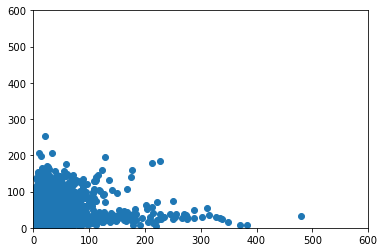

In [ ]:
plt.plot(lab_chemprop_complete[['ca_nh4_ph_7', 'mg_nh4_ph_7', 'na_nh4_ph_7', 'k_nh4_ph_7', 
                                'aluminum_kcl_extractable']].sum(axis = 1), 
         lab_chemprop_complete['cec_nh4_ph_7'], 'o')
plt.xlim([0,600])
plt.ylim([0,600])

In [ ]:
filter = (lab_chemprop_complete['cec_nh4_ph_7'] > \
    lab_chemprop_complete[['ca_nh4_ph_7', 'mg_nh4_ph_7', 'na_nh4_ph_7', 'k_nh4_ph_7', 
                           'aluminum_kcl_extractable']].sum(axis = 1))
lab_chemprop_complete.loc[filter, :].shape

(69047, 19)

(0.0, 600.0)

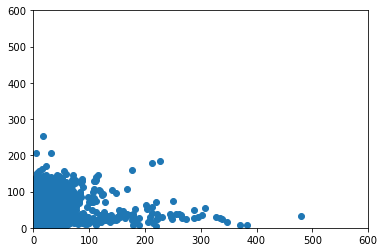

In [ ]:
temp = lab_chemprop_complete.loc[lab_chemprop_complete['cec_nh4_ph_7_method'] == '4B1a1a', :]
plt.plot(temp[['ca_nh4_ph_7', 'mg_nh4_ph_7', 'na_nh4_ph_7', 'k_nh4_ph_7']].sum(axis = 1), 
         temp['cec_nh4_ph_7'], 'o')
plt.xlim([0,600])
plt.ylim([0,600])

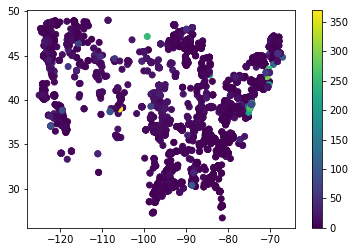

In [ ]:
temp2 = temp.loc[temp['hzn_bot'] <= 30, :]
x = temp2['lon']
y = temp2['lat']
z = temp2[['ca_nh4_ph_7', 'mg_nh4_ph_7', 'na_nh4_ph_7', 'k_nh4_ph_7']].sum(axis = 1)
plt.scatter(x, y, c = z)
plt.colorbar()

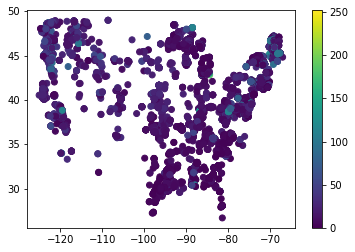

In [ ]:
temp2 = temp.loc[temp['hzn_bot'] <= 30, :]
x = temp2['lon']
y = temp2['lat']
z = temp2[['cec_nh4_ph_7']].sum(axis = 1)
plt.scatter(x, y, c = z)
plt.colorbar()

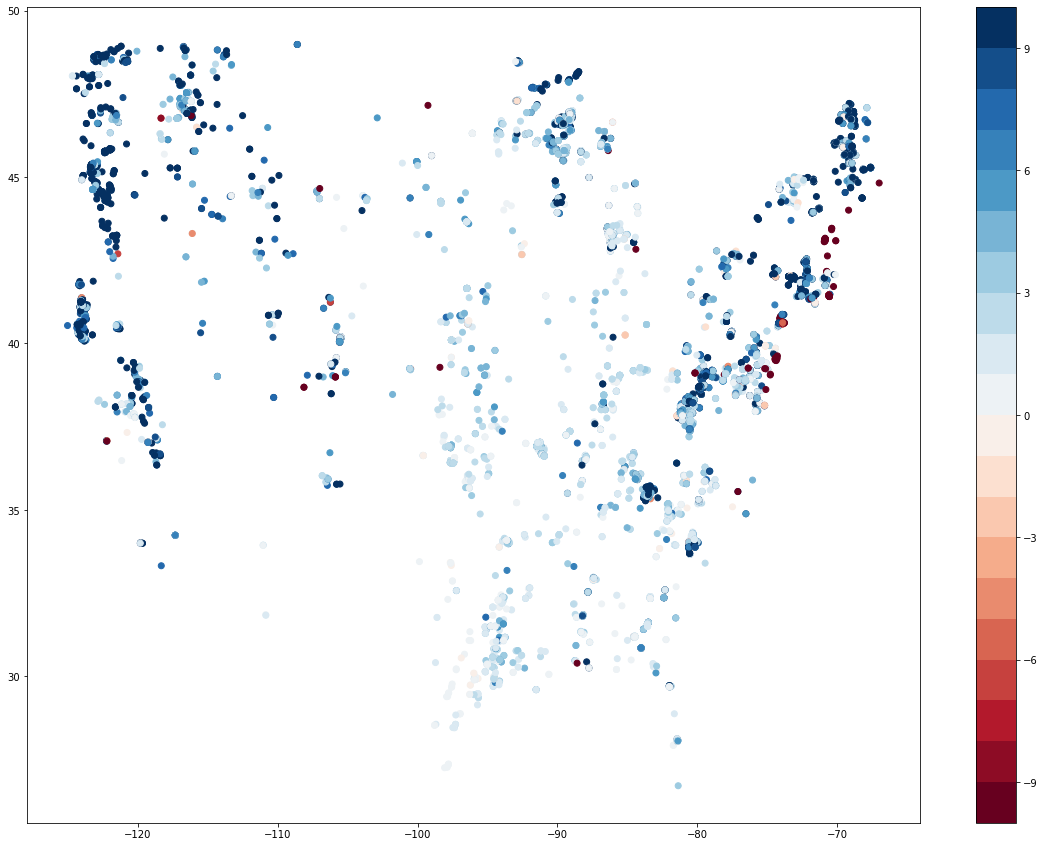

In [ ]:
temp2 = temp.loc[temp['hzn_bot'] <= 30, :]
x = temp2['lon']
y = temp2['lat']
z = temp2[['cec_nh4_ph_7']].sum(axis = 1) - \
    temp2[['ca_nh4_ph_7', 'mg_nh4_ph_7', 'na_nh4_ph_7', 'k_nh4_ph_7', 'aluminum_kcl_extractable']].sum(axis = 1)

from matplotlib.colors import BoundaryNorm

cmap = plt.cm.get_cmap('RdBu')
plt.figure(figsize = (20,15))
plt.scatter(x, y, c = z, cmap = 'RdBu', norm = BoundaryNorm(np.linspace(-10, 10, 21), cmap.N))
plt.colorbar()

### Filter data to only when total CEC < sum of bases and Al

In [ ]:
# convert the CEC values to total CEC and fractions
lab_newdata = pd.DataFrame(np.nan, index = lab_chemprop_complete.index, 
                           columns = ['CEC_tot', 'beta_Ca', 'beta_Mg', 'beta_Na', 'beta_K', 
                                      'beta_Al', 'lat', 'lon', 'hzn_top', 'hzn_bot'])
lab_newdata.loc[:, 'CEC_tot'] = lab_chemprop_complete['cec_nh4_ph_7'].copy()
#    lab_chemprop_complete['ca_nh4_ph_7'] + \
#    lab_chemprop_complete['mg_nh4_ph_7'] + lab_chemprop_complete['na_nh4_ph_7'] + \
#    lab_chemprop_complete['k_nh4_ph_7'] + lab_chemprop_complete['aluminum_kcl_extractable'] + \
#    lab_chemprop_complete['acidity_bacl2_tea_ph_8_2']
lab_newdata.loc[:, 'beta_Ca'] = lab_chemprop_complete['ca_nh4_ph_7'] / lab_newdata['CEC_tot']
lab_newdata.loc[:, 'beta_Mg'] = lab_chemprop_complete['mg_nh4_ph_7'] / lab_newdata['CEC_tot']
lab_newdata.loc[:, 'beta_Na'] = lab_chemprop_complete['na_nh4_ph_7'] / lab_newdata['CEC_tot']
lab_newdata.loc[:, 'beta_K'] = lab_chemprop_complete['k_nh4_ph_7'] / lab_newdata['CEC_tot']
lab_newdata.loc[:, 'beta_Al'] = lab_chemprop_complete['aluminum_kcl_extractable'] / lab_newdata['CEC_tot']

# reset the < 0 value to 1e-3
lab_newdata.loc[:, 'beta_Ca'] = lab_newdata['beta_Ca'].clip(lower = 0.001)
lab_newdata.loc[:, 'beta_Mg'] = lab_newdata['beta_Mg'].clip(lower = 0.001)
lab_newdata.loc[:, 'beta_Na'] = lab_newdata['beta_Na'].clip(lower = 0.001)
lab_newdata.loc[:, 'beta_K'] = lab_newdata['beta_K'].clip(lower = 0.001)
lab_newdata.loc[:, 'beta_Al'] = lab_newdata['beta_Al'].clip(lower = 0.001)

lab_newdata = lab_newdata.loc[lab_newdata[['beta_Ca','beta_Mg','beta_Na','beta_K','beta_Al']].sum(axis = 1) < 1, :]

# remove the values where CEC_tot = 0
lab_newdata = lab_newdata.loc[lab_newdata['CEC_tot'] > 1e-8, :]

lab_newdata.loc[:,['lat', 'lon', 'hzn_top', 'hzn_bot']] = \
    lab_chemprop_complete.loc[:,['lat', 'lon', 'hzn_top', 'hzn_bot']]

lab_newdata = lab_newdata.reset_index()

lab_newdata

,site_key,layer_key,CEC_tot,beta_Ca,beta_Mg,beta_Na,beta_K,beta_Al,lat,lon,hzn_top,hzn_bot
0,1,1,13.5,0.322222,0.078519,0.028148,0.031111,0.050370,40.768703,-73.979195,0.0,5.0
1,1,2,7.3,0.152055,0.036986,0.030137,0.016438,0.243836,40.768703,-73.979195,5.0,12.0
2,1,3,4.4,0.111364,0.027273,0.045455,0.022727,0.431818,40.768703,-73.979195,12.0,27.0
3,1,4,5.0,0.118000,0.030000,0.054000,0.014000,0.312000,40.768703,-73.979195,27.0,64.0
4,1,5,3.7,0.245946,0.067568,0.059459,0.005405,0.332432,40.768703,-73.979195,64.0,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...
69021,137051,15954388,37.3,0.125201,0.031635,0.001609,0.007507,0.423592,44.507641,-122.687973,42.0,65.0
69022,137051,15954389,39.8,0.096482,0.022111,0.001508,0.006533,0.488693,44.507641,-122.687973,65.0,86.0
69023,137051,15954390,41.2,0.066505,0.017476,0.001000,0.006311,0.525485,44.507641,-122.687973,86.0,99.0
69024,137052,15954394,23.5,0.200851,0.026809,0.003404,0.006383,0.078723,44.448021,-122.546181,59.0,83.0


## 0. Check if there is data near the UC-Davis site

In [ ]:
target_lat = 38.53339
target_lon = -121.76588

# focus on sites within 1 degree
distance = np.power(lab_newdata['lat'] - target_lat, 2) + \
           np.power(lab_newdata['lon'] - target_lon, 2)
lab_newdata.iloc[np.argsort(distance)[distance < 1], :]

,site_key,layer_key,CEC_tot,beta_Ca,beta_Mg,beta_Na,beta_K,beta_Al,lat,lon,hzn_top,hzn_bot
8970,14414,91612,9.9,0.015152,0.001000,0.001000,0.027273,0.287879,42.298744,-120.161614,13.0,33.0
14616,19681,123899,28.6,0.032867,0.016084,0.002448,0.015035,0.154895,42.004818,-124.145332,15.0,36.0
14615,19681,123898,38.8,0.082474,0.034021,0.003093,0.018814,0.131701,42.004818,-124.145332,0.0,15.0
68503,136371,15950794,10.6,0.190566,0.036792,0.001887,0.046226,0.055660,42.756153,-122.010452,2.0,20.0
2494,5727,42575,20.5,0.434146,0.151220,0.004878,0.024390,0.009756,42.487598,-123.288094,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12798,18211,113837,3.3,0.001000,0.015152,0.001000,0.001000,0.409091,41.672756,-70.809456,18.0,26.0
34163,43165,15770060,7.8,0.001000,0.001000,0.001000,0.001000,0.687179,45.669861,-69.459587,5.0,10.0
34167,43165,15770064,3.0,0.001000,0.043333,0.001000,0.030000,0.393333,45.669861,-69.459587,56.0,165.0
34166,43165,15770063,3.4,0.001000,0.005882,0.001000,0.001000,0.417647,45.669861,-69.459587,46.0,56.0


<AxesSubplot:>

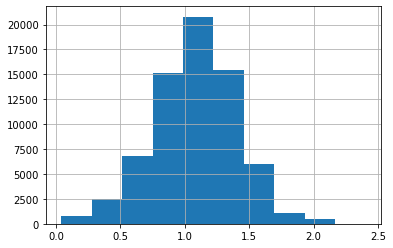

In [ ]:
np.log10(lab_newdata['CEC_tot'] + 1).hist()

## 1. Check data availability

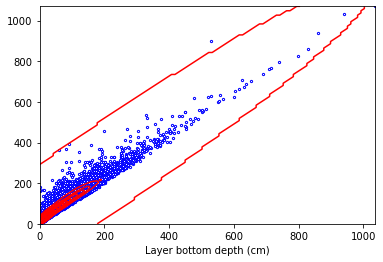

In [ ]:
x = lab_newdata['hzn_top'].values
y = lab_newdata['hzn_bot'].values
#y = y[x < 30]
#x = x[x < 30]
kde = gaussian_kde([x[::100], y[::100]])

# Creating a grid of values
xgrid = np.linspace(x.min(), x.max(), 100)
ygrid = np.linspace(y.min(), y.max(), 100)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde(np.vstack([Xgrid.ravel(), Ygrid.ravel()])).reshape(Xgrid.shape)

fig, ax = plt.subplots()
ax.scatter(x, y, s=5, facecolor='white', edgecolor='blue')
ax.contour(Xgrid, Ygrid, Z, colors='red', levels=20)
#ax.set_xlim([0, 100])
#ax.set_ylim([0, 50])
ax.set_xlabel('Layer top depth (cm)')
ax.set_xlabel('Layer bottom depth (cm)')
plt.show()

0    2458
1    2655
2    6797
3    6146
4    5695
5    5399
dtype: int64

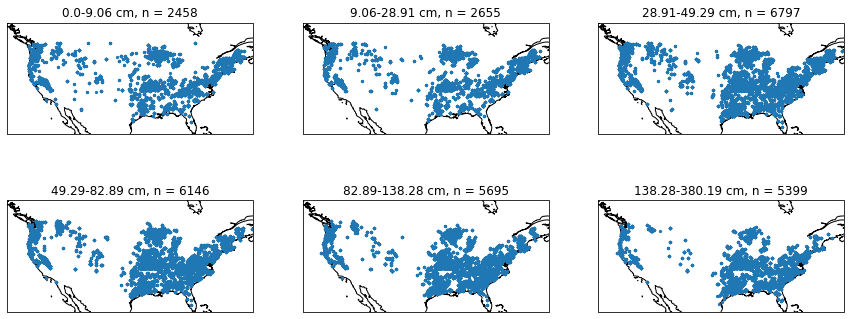

In [ ]:
# convert from m to cm; Table 6.1 Soil Layer structure, CLM4.5 doc
# Merge the top 10cm into one because too few observations
# 0.0175, 0.0451, 0.0906, 
# Merge the 10-30cm into one because too few observations
# 0.1655, 0.2891, 
# Below 1.38m doesn't have much data; use relaxed criteria here then
# 1.3828, 2.2961, 3.8019, merge those layers too
elm_bot = 100 * np.array([ 0.0906, 0.2891, 0.4929, 0.8289, 1.3828, 3.8019])
elm_top = np.insert(elm_bot[:-1], 0, 0)

num_obs = pd.Series(0, index = range(len(elm_bot)))

fig, axes = plt.subplots(2, 3, figsize = (15, 6), subplot_kw={'projection': ccrs.PlateCarree()})
for i, (top, bottom) in enumerate(zip(elm_top, elm_bot)):
    if i == 0:
        top_above = -0.1
    else:
        top_above = elm_top[i-1]
    if i == len(elm_bot) - 1:
        bot_below = 4.7392
    else:
        bot_below = elm_bot[i+1]

    # layer starts one layer above, and ends in the layer
    # 0.1 allows some inaccuracies
    straddle_top = lab_newdata.query('hzn_top > @top_above and hzn_top < (@top+0.1) and hzn_bot > @top and hzn_bot < @bottom')
    straddle_top = straddle_top.reset_index().set_index('site_key').sort_index()

    # layer starts in the layer, and ends one layer below
    # 0.1 allows some inaccuracies
    straddle_bot = lab_newdata.query('hzn_top > @top and hzn_top < @bottom and hzn_bot > (@bottom-0.1) and hzn_bot < @bot_below')
    straddle_bot = straddle_bot.reset_index().set_index('site_key').sort_index()

    if top < 138:
        # layer must be exact match
        middle = lab_newdata.query('abs(hzn_top - @top) < 0.1 and abs(hzn_bot - @bottom) < 0.1')
        middle = middle.reset_index().set_index('site_key').sort_index()
    else:
        # so long as there are some observations in the middle
        middle = lab_newdata.query('hzn_top >= (@top - 0.1) and hzn_bot <= (@bottom + 0.1)')
        middle = middle.reset_index().set_index('site_key').sort_index()

    # site must have one observation that's an exact match, 
    # or have observations for both straddling layers (there
    # may be additional layers in the middle that we do not care)
    site_with_obs = middle.index.union(straddle_top.index.intersection(straddle_bot.index))
    bool_obs = lab_newdata['site_key'].isin(site_with_obs)

    # Check the number of points for individual cations
    #for col in lab_chemical_properties.columns:
    #    site_subset = lab_chemical_properties.loc[~lab_chemical_properties[col].isna(), 'site_key'].drop_duplicates()
    #    num_obs.loc[i, col] = len(has_obs.intersection(list(site_subset)))
    num_obs.loc[i] = len(site_with_obs)

    ax = axes.flat[i]
    ax.coastlines()
    ax.set_extent([-130, -65, 25, 50])
    ax.scatter(lab_newdata.loc[bool_obs, 'lon'], lab_newdata.loc[bool_obs, 'lat'], s = 5)
    ax.set_title(f'{np.around(top,2)}-{np.around(bottom,2)} cm, n = {num_obs.loc[i]}')
num_obs

## 2. Perform depth interpolation

In [ ]:
elm_bot = 100 * np.array([0.0906, 0.2891, 0.4929, 0.8289, 1.3828, 3.8019])
elm_top = np.insert(elm_bot[:-1], 0, 0)

xlswriter = pd.ExcelWriter(os.path.join(path_out, 'interp_NCSS.xlsx'), engine='openpyxl')

for i, (top, bottom) in enumerate(zip(elm_top, elm_bot)):
    if i == 0:
        top_above = -0.1
    else:
        top_above = elm_top[i-1]
    if i == len(elm_bot) - 1:
        bot_below = 4.7392
    else:
        bot_below = elm_bot[i+1]

    # layer starts one layer above, and ends in the layer
    # 0.1 allows some inaccuracies
    straddle_top = lab_newdata.query('hzn_top > @top_above and hzn_top < (@top+0.1) and hzn_bot > @top and hzn_bot < @bottom')

    # layer starts in the layer, and ends one layer below
    # 0.1 allows some inaccuracies
    straddle_bot = lab_newdata.query('hzn_top > @top and hzn_top < @bottom and hzn_bot > (@bottom-0.1) and hzn_bot < @bot_below')

    if top < 138:
        # layer must be exact match
        middle = lab_newdata.query('abs(hzn_top - @top) < 0.1 and abs(hzn_bot - @bottom) < 0.1')
    else:
        # so long as there are some observations in the middle
        middle = lab_newdata.query('hzn_top >= (@top - 0.1) and hzn_bot <= (@bottom + 0.1)')

    # site must have one observation that's an exact match, 
    # or have observations for both straddling layers
    use_exact = list(middle['site_key'].drop_duplicates())
    use_interp = set(straddle_top['site_key']) & set(straddle_bot['site_key'])
    use_interp = list(use_interp.difference(use_exact))
    interp_values = pd.DataFrame(np.nan, 
                                 index = use_exact + use_interp,
                                 columns = ['CEC_tot', 'beta_Ca', 'beta_Mg', 'beta_Na', 'beta_K', 'beta_Al', 'lat', 'lon'])

    # (1) the case using middle values - simply average
    interp_values.loc[use_exact, :] = lab_newdata.loc[middle.index, ['site_key'] + list(interp_values.columns)].groupby('site_key').mean()

    # (2) the case needing interpolation - weighted average using the
    #     fraction overlapping with the layer; note in addition to straddle_top
    #     and straddle_bot, there may be other observations not covering the whole layer
    straddle_mid = lab_newdata.query('hzn_top > @top and hzn_bot < @bottom')
    straddle_layers = list(
        set(straddle_top.index[straddle_top['site_key'].isin(use_interp)]) | \
        set(straddle_bot.index[straddle_bot['site_key'].isin(use_interp)]) | \
        set(straddle_mid.index[straddle_mid['site_key'].isin(use_interp)]) )

    to_interpolate = lab_newdata.loc[straddle_layers, :]

    layer_thickness = lab_newdata.loc[straddle_layers, 'hzn_bot'] - lab_newdata.loc[straddle_layers, 'hzn_top']
    overlap_thickness = \
        np.minimum(
            lab_newdata.loc[straddle_layers, 'hzn_bot'].values, 
            bottom
        ) - np.maximum(
            lab_newdata.loc[straddle_layers, 'hzn_top'].values, 
            top
        )
    layer_weight = overlap_thickness / layer_thickness

    for col in interp_values.columns:
        weighted_sum = to_interpolate[col] * layer_weight
        weight_sum = ~(to_interpolate[col].isna()) * layer_weight
        temp = pd.concat([weighted_sum, weight_sum, 
                          to_interpolate[['site_key','lat','lon']]],
                         axis = 1)
        temp.columns = ['weighted_sum', 'weight_sum', 'site_key', 'lat', 'lon']
        temp = temp.groupby('site_key').sum()
        temp = temp['weighted_sum'] / temp['weight_sum']
        interp_values.loc[temp.index, col] = temp

    interp_values.to_excel(xlswriter, sheet_name = f'layer_{i}')
xlswriter.close()

In [ ]:
os.path.join(path_out, 'interp_NCSS.xlsx')

'/lustre/or-scratch/cades-ccsi/scratch/ywo/ERW_LDRD/results/interp_NCSS.xlsx'

## 3. Perform spatial interpolation

Save to geotiff

In [ ]:
dummy() # stop here

NameError: name 'dummy' is not defined

In [ ]:
def idw_interpolation(x, y, z, xi, yi, power=2):
    distances = distance_matrix(np.column_stack([x, y]), np.column_stack([xi.ravel(), yi.ravel()]))
    weights = 1.0 / distances**power
    weights /= weights.sum(axis=0)
    zi = np.dot(weights.T, z)
    return zi.reshape(xi.shape)

In [ ]:
""" Need to run this on a server to have enough memory """
elm_bot = 100 * np.array([0.0906, 0.2891, 0.4929, 0.8289, 1.3828, 3.8019])
elm_top = np.insert(elm_bot[:-1], 0, 0)

for i, (top, bottom) in enumerate(zip(elm_top, elm_bot)):
    interp_values = pd.read_excel(os.path.join(path_out, 'interp_NCSS.xlsx'), 
                                  sheet_name = f'layer_{i}', index_col = 0)

    for j, col in enumerate(['CEC_tot', 'beta_Ca', 'beta_Mg', 'beta_Na', 'beta_K', 'beta_Al']):

        values = interp_values[[col]].dropna()
        gdf = interp_values.loc[:, [col, 'lat', 'lon']]
        gdf = gpd.GeoDataFrame(gdf,
                               geometry=gpd.points_from_xy(gdf['lon'], gdf['lat']),
                               crs='EPSG:4326')

        # Converting lat-lon to a projected coordinate system for distance accuracy
        gdf = gdf.to_crs('EPSG:5070') # OC

        # gdf.to_file(os.path.join('..', 'results', f'interp_NCSS_layer_{i}_{col}.shp'))

        # Extract coordinates and values
        x = gdf.geometry.x.values
        y = gdf.geometry.y.values
        values = gdf[col].values.astype(np.float32)

        # Create a grid where interpolation will be performed
        grid_x = np.arange(np.around(min(x)), np.around(max(x)) + 200000, 10000)
        grid_y = np.arange(np.around(max(y)) + 100000, np.around(min(y)) - 100000, -10000)
        grid_x, grid_y = np.meshgrid(grid_x, grid_y)

        z = idw_interpolation(x, y, values, grid_x, grid_y)

        """# Perform Ordinary Kriging
        ok = OrdinaryKriging(
            x, y, values,
            variogram_model='linear',
            verbose=False,
            enable_plotting=False
        )
        z, ss = ok.execute('grid', grid_x, grid_y)"""

        # use gdal to save to geotiff
        srs = osr.SpatialReference()
        srs.ImportFromEPSG(5070)

        geotransform = (grid_x[0, 0], 10000, 0, grid_y[0, 0], 0, -10000)

        gdal_data_type = gdal.GDT_Float32

        # Create the file
        driver = gdal.GetDriverByName('GTiff')
        output_file = os.path.join(path_out, f'interp_NCSS_layer_{i}_{col}.tif')
        dataset = driver.Create(output_file, z.shape[1], z.shape[0], 1, gdal_data_type)

        # Set the geotransform and projection
        dataset.SetGeoTransform(geotransform)
        dataset.SetProjection(srs.ExportToWkt())

        # Get the raster band
        band = dataset.GetRasterBand(1)

        # Write the array to band
        band.WriteArray(z)
        band.SetNoDataValue(np.nan)  # Assuming 'nan' is your no-data value

        # Clean up
        band.FlushCache()
        dataset = None

## 4. Extract the values at the UC-Davis and Hubbard Brook sites

Requires the `gee` environment; `myCondaEnv`'s pyproj installation has problem

The units see `NCSSLabDataMart_LabMethodsCodeTechNote.pdf`, page 338

"in units of centimoles per kg of soil (cmol(+) kg−1) or milliequivalents per 100 g of soil (meq 100 g−1). The KSSL reports cmol(+) kg−1 on a <2-mm air-dry basis."

In [3]:
def latlon_to_pixel(lat, lon, affine, crs = None):
    if not crs is None:
        proj_latlon = CRS.from_epsg(4326)
        proj_dataset = CRS.from_wkt(crs)
        transformer = Transformer.from_crs(proj_latlon, proj_dataset, always_xy=True)
        x, y = transformer.transform(lon, lat)
    else:
        x, y = lon, lat
    # Create an affine transformation to convert from lat/lon to pixel coordinates
    row, col = rio.transform.rowcol(affine, x, y)

    return row, col


elm_bot = 100 * np.array([0.0906, 0.2891, 0.4929, 0.8289, 1.3828, 3.8019])
elm_top = np.insert(elm_bot[:-1], 0, 0)

coords = {
    'HBR_1': (-71.728825, 43.9556695),
    'HBR_2': (-71.728825, 43.9556695),
    'UC_Davis': (-121.781708, 38.531656)
}

values = pd.DataFrame(np.nan, 
                      index = pd.MultiIndex.from_product([['HBR_1', 'HBR_2', 'UC_Davis'], 
                                          [f'layer_{i}' for i in range(len(elm_top))]]), 
                      columns = ['CEC_tot', 'beta_Ca', 'beta_Mg', 'beta_Na', 'beta_K', 'beta_Al'])
for i, (top, bottom) in enumerate(zip(elm_top, elm_bot)):
    for j, col in enumerate(values.columns):
        h = rio.open(os.path.join(path_out, f'interp_NCSS_layer_{i}_{col}.tif'))
        data = h.read(1, masked = True)
        for site in ['HBR_1', 'HBR_2', 'UC_Davis']:
            x, y = latlon_to_pixel(coords[site][1], coords[site][0], h.transform, 
                                   crs = h.crs.to_wkt())
            values.loc[(site, f'layer_{i}'), col] = data[x, y]
        h.close()
values.to_csv(os.path.join(path_out, 'interp_NCSS_results.csv'))
values

CEC_tot   beta_Ca   beta_Mg   beta_Na    beta_K   beta_Al
HBR_1    layer_0  46.942043  0.056945  0.011728  0.005429  0.007390  0.259713
         layer_1  32.816971  0.022265  0.006033  0.008416  0.005723  0.267025
         layer_2  19.501162  0.011910  0.003191  0.002170  0.002401  0.235681
         layer_3  12.140118  0.011998  0.002951  0.004486  0.003442  0.246001
         layer_4   3.494821  0.034105  0.015441  0.018677  0.013016  0.199998
         layer_5   6.988371  0.187785  0.101784  0.022939  0.024120  0.246730
HBR_2    layer_0  46.942043  0.056945  0.011728  0.005429  0.007390  0.259713
         layer_1  32.816971  0.022265  0.006033  0.008416  0.005723  0.267025
         layer_2  19.501162  0.011910  0.003191  0.002170  0.002401  0.235681
         layer_3  12.140118  0.011998  0.002951  0.004486  0.003442  0.246001
         layer_4   3.494821  0.034105  0.015441  0.018677  0.013016  0.199998
         layer_5   6.988371  0.187785  0.101784  0.022939  0.024120  0.246730
UC_Davis layer_0  23.665220  0.399636  0.120401  0.009624  0.037661  0.045376
         layer_1  16.749022  0.254483  0.097693  0.017642  0.027135  0.090930
         layer_2  19.196865  0.265064  0.131296  0.021212  0.029112  0.096856
         layer_3  25.365709  0.234072  0.131945  0.025120  0.026383  0.122679
         layer_4  29.761194  0.266159  0.153523  0.019019  0.021170  0.131874
         layer_5  22.581041  0.277264  0.153209  0.016505  0.018859  0.133066

In [4]:
# Convert beta to CEC
cec_values = pd.DataFrame(np.nan, 
    index = pd.MultiIndex.from_product([['HBR_1', 'UC_Davis'], 
                                        [f'layer_{i}' for i in range(len(elm_top))]]), 
    columns = ['CEC_tot', 'CEC_Ca', 'CEC_Mg', 'CEC_Na', 'CEC_K', 'CEC_Al'])
cec_values['CEC_tot'] = values.loc[['HBR_1', 'UC_Davis'], 'CEC_tot'].values

for cation in ['Ca', 'Mg', 'Na', 'K', 'Al']:
    cec_values.loc[:, f'CEC_{cation}'] = \
        (values[f'beta_{cation}'] * values['CEC_tot']).loc[['HBR_1', 'UC_Davis'], :].values
cec_values['CEC_h'] = values['CEC_tot'] * (1 - values.drop('CEC_tot', axis = 1).sum(axis = 1))
cec_values

CEC_tot    CEC_Ca    CEC_Mg    CEC_Na     CEC_K  \
HBR_1    layer_0  46.942043  2.673134  0.550523  0.254855  0.346891   
         layer_1  32.816971  0.730671  0.197975  0.276174  0.187799   
         layer_2  19.501162  0.232263  0.062222  0.042312  0.046828   
         layer_3  12.140118  0.145654  0.035830  0.054457  0.041790   
         layer_4   3.494821  0.119189  0.053962  0.065273  0.045488   
         layer_5   6.988371  1.312310  0.711303  0.160307  0.168561   
UC_Davis layer_0  23.665220  9.457466  2.849322  0.227762  0.891247   
         layer_1  16.749022  4.262346  1.636269  0.295490  0.454478   
         layer_2  19.196865  5.088406  2.520476  0.407207  0.558851   
         layer_3  25.365709  5.937407  3.346886  0.637179  0.669218   
         layer_4  29.761194  7.921200  4.569032  0.566042  0.630031   
         layer_5  22.581041  6.260910  3.459618  0.372691  0.425851   

                     CEC_Al      CEC_h  
HBR_1    layer_0  12.191467  30.925175  
         layer_1   8.762940  22.661413  
         layer_2   4.596058  14.521480  
         layer_3   2.986486   8.875900  
         layer_4   0.698956   2.511953  
         layer_5   1.724238   2.911651  
UC_Davis layer_0   1.073827   9.165596  
         layer_1   1.522996   8.577442  
         layer_2   1.859331   8.762594  
         layer_3   3.111831  11.663187  
         layer_4   3.924725  12.150164  
         layer_5   3.004765   9.057205